### Load libraries and functions

In [229]:

import sys
sys.path.insert(0, '../src/')

from loopless_utils import loops_enumeration_from_fva, loopy_reactions_turned_off_in_pfba

from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model
from load_modify_sample_utils import sample_optgp

from correlations_utils import correlated_reactions, split_forward_reverse
from correlations_utils import find_reactants_products

from graphs_utils import construct_graph, plot_graph, compute_nodes_centrality_metrics
from graphs_utils import compare_network_modularities, compare_node_centralities, compare_essential_to_network_central_reactions

from pathways_utils import dictionary_reaction_id_to_kegg_id, get_kegg_pathways_from_reaction_ids
from pathways_utils import map_model_to_kegg_reactions_dictionary, read_json_file, fill_missing_kegg_ids_in_initial_dictionary
from pathways_utils import subset_model_reactions_from_pathway_info, subset_sampling_array_from_reaction_ids, sort_reactions_by_model_order
from pathways_utils import dictionary_reaction_id_to_pathway, dictionary_map_reverse_reaction_id_to_pathway


### Load and inspect model (for more info see `load_modify_samply.ipynb`)

For the core model

In [218]:

ec_cobra_model, ec_cobra_reactions, ec_cobra_reaction_ids,  = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds)


['BIOMASS_Ecoli_core_w_GAM']
{'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.0), 'D_LACt2': (-1000.0, 1000.0), 'ENO': (-1000.0, 1000.0), 'SUCCt3': (0.0, 1000.0), 'ETOHt2r': (-1000.0, 1000.0), 'SUCDi': (0.0, 10

For the iCH360 model

In [215]:

iCH360_cobra_model, iCH360_cobra_reactions, iCH360_cobra_reaction_ids,  = load_model("../ext_data/models/Escherichia_coli_iCH360.xml")

objective_functions = get_objective_functions(iCH360_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(iCH360_cobra_model)
print(default_reaction_bounds)


['Biomass']
{'NDPK5': (-1000.0, 1000.0), 'SHK3Dr': (-1000.0, 1000.0), 'NDPK6': (-1000.0, 1000.0), 'NDPK8': (-1000.0, 1000.0), 'DHORTS': (-1000.0, 1000.0), 'OMPDC': (0.0, 1000.0), 'G5SD': (0.0, 1000.0), 'CS': (0.0, 1000.0), 'ICDHyr': (-1000.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'PPA': (0.0, 1000.0), 'PPCK': (0.0, 1000.0), 'ME1': (0.0, 1000.0), 'ALATA_L': (-1000.0, 1000.0), 'XYLK': (0.0, 1000.0), 'RBK': (0.0, 1000.0), 'GLYK': (0.0, 1000.0), 'ASPTA': (-1000.0, 1000.0), 'FBP': (0.0, 1000.0), 'EX_pi_e': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'EX_co2_e': (-1000.0, 1000.0), 'GTHOr': (-1000.0, 1000.0), 'ILETA': (-1000.0, 1000.0), 'DHORD5': (0.0, 1000.0), 'VALTA': (-1000.0, 1000.0), 'IPPMIb': (-1000.0, 1000.0), 'ORPT': (-1000.0, 1000.0), 'ACHBS': (0.0, 1000.0), 'DHAD2': (0.0, 1000.0), 'ACLS': (0.0, 1000.0), 'TRPS2': (0.0, 1000.0), 'PSCVT': (-1000.0, 1000.0), 'PFL': (0.0, 1000.0), 'ANS': (0.0, 1000.0), 'FRD2': (0.0, 1000.0), 'ANPRT': (0.0, 1000.0), 'CHORM': (0.0, 1000.0), 'PTAr': (-1000.0, 1

### Modify the model to create two different conditions (for more info see `load_modify_samply.ipynb`)

For the core model

In [235]:

# Set optimal percentage to 100
ec_cobra_model_condition_100 = modify_model(
    cobra_model         = ec_cobra_model,
    
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    
    optimal_percentage  = 100,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_100)
print(updated_objective_functions)


# Set optimal percentage to 0
ec_cobra_model_condition_0 = modify_model(
    cobra_model         = ec_cobra_model,
    
    objective_function  = "BIOMASS_Ecoli_core_w_GAM",
    
    optimal_percentage  = 0,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(ec_cobra_model_condition_0)
print(updated_objective_functions)


Read LP format model from file /tmp/tmprii7grr6.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['BIOMASS_Ecoli_core_w_GAM']
Read LP format model from file /tmp/tmptebymbhl.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
['BIOMASS_Ecoli_core_w_GAM']


For the iCH360 model

In [234]:

# Set optimal percentage to 100
iCH360_cobra_model_condition_100 = modify_model(
    cobra_model         = iCH360_cobra_model,
    
    objective_function  = "Biomass",
    
    optimal_percentage  = 100,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(iCH360_cobra_model_condition_100)
print(updated_objective_functions)

# -----------

# Set optimal percentage to 0
iCH360_cobra_model_condition_0 = modify_model(
    cobra_model         = iCH360_cobra_model,
    
    objective_function  = "Biomass",
    
    optimal_percentage  = 0,
    objective_direction = "max"
)

updated_objective_functions = get_objective_functions(iCH360_cobra_model_condition_0)
print(updated_objective_functions)


Read LP format model from file /tmp/tmpzbpftwen.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros
['Biomass']
Read LP format model from file /tmp/tmpxgzkflqw.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros
['Biomass']


### Identify loopy reactions in model (for more info see `loopless.ipynb`)

For the core model

In [236]:

core_loopy_reactions_fva_100 = loops_enumeration_from_fva(ec_cobra_model_condition_100, fraction_of_optimum=0.999)
print(core_loopy_reactions_fva_100)

core_loopy_reactions_100 = [item[0] for item in core_loopy_reactions_fva_100]
print(core_loopy_reactions_100)


core_loopy_reactions_fva_0 = loops_enumeration_from_fva(ec_cobra_model_condition_0, fraction_of_optimum=0)
print(core_loopy_reactions_fva_0)

core_loopy_reactions_0 = [item[0] for item in core_loopy_reactions_fva_0]
print(core_loopy_reactions_0)


[('SUCDi', 994.7794007141792), ('FRD7', 995.0539767141795)]
['SUCDi', 'FRD7']
[('SUCDi', 980.0), ('FRD7', 1000.0)]
['SUCDi', 'FRD7']


For the iCH360 model

In [237]:

iCH360_loopy_reactions_fva_100 = loops_enumeration_from_fva(iCH360_cobra_model_condition_100, fraction_of_optimum=0.999)
print(iCH360_loopy_reactions_fva_100)

iCH360_loopy_reactions_100 = [item[0] for item in iCH360_loopy_reactions_fva_100]
print(iCH360_loopy_reactions_100)


iCH360_loopy_reactions_fva_0 = loops_enumeration_from_fva(iCH360_cobra_model_condition_0, fraction_of_optimum=0)
print(iCH360_loopy_reactions_fva_0)

iCH360_loopy_reactions_0 = [item[0] for item in iCH360_loopy_reactions_fva_0]
print(iCH360_loopy_reactions_0)


[('ALATA_L', 1998.257802712621), ('VALTA', 1998.257802712621), ('VPAMTr', 1998.257802712621)]
['ALATA_L', 'VALTA', 'VPAMTr']
[('ALATA_L', 2000.0), ('VALTA', 1999.1289013408882), ('VPAMTr', 2000.0)]
['ALATA_L', 'VALTA', 'VPAMTr']


### Remove loopy reactions from the 2 models created above to reduce the thermodynamically infeasible solutions from sampling

For the core model manually

In [223]:

ec_cobra_model_condition_100.reactions.get_by_id("FRD7").bounds = (0, 0)
ec_cobra_model_condition_0.reactions.get_by_id("FRD7").bounds = (0, 0)


For the core model with the `loopy_reactions_turned_off_in_pfba` function

In [238]:

turned_off_reactions = loopy_reactions_turned_off_in_pfba(ec_cobra_model_condition_100, core_loopy_reactions_100, tol = 1e-6)
print(turned_off_reactions)


Read LP format model from file /tmp/tmphm4xf5is.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
['FRD7']


For the iCH360 model manually

In [ ]:

iCH360_cobra_model_condition_100.reactions.get_by_id("VPAMTr").bounds = (0, 0)
iCH360_cobra_model_condition_0.reactions.get_by_id("VPAMTr").bounds = (0, 0)


For the iCH360 model with the `loopy_reactions_turned_off_in_pfba` function

In [239]:

iCH360_turned_off_reactions_100 = loopy_reactions_turned_off_in_pfba(iCH360_cobra_model_condition_100, iCH360_loopy_reactions_100, tol = 1e-6)
print(iCH360_turned_off_reactions_100)

iCH360_turned_off_reactions_0 = loopy_reactions_turned_off_in_pfba(iCH360_cobra_model_condition_0, iCH360_loopy_reactions_0, tol = 1e-6)
print(iCH360_turned_off_reactions_0)


Read LP format model from file /tmp/tmpl4kxxihv.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros
['VPAMTr']
Read LP format model from file /tmp/tmpem1_3_lq.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros


/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


['VPAMTr']


### Perform sampling on the modified models with the loopy reaction "FRD7" removed. (for more info see `load_modify_samply.ipynb`)

For the core model

In [241]:

samples_optgp_condition_100 = sample_optgp(ec_cobra_model_condition_100, 
                                           n_samples = 3000, 
                                           thinning=100, 
                                           reaction_in_rows = True)

samples_optgp_condition_0 = sample_optgp(ec_cobra_model_condition_0, 
                                         n_samples = 3000, 
                                         thinning=100, 
                                         reaction_in_rows = True)


Read LP format model from file /tmp/tmprtf986jc.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpfi7cl5e3.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros


For the iCH360 model

In [240]:

samples_optgp_condition_100 = sample_optgp(iCH360_cobra_model_condition_100, 
                                           n_samples = 3000, 
                                           thinning=100, 
                                           reaction_in_rows = True)

samples_optgp_condition_0 = sample_optgp(iCH360_cobra_model_condition_0, 
                                         n_samples = 3000, 
                                         thinning=100, 
                                         reaction_in_rows = True)


Read LP format model from file /tmp/tmpihbp8n44.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros
Read LP format model from file /tmp/tmpzkzapla4.lp
Reading time = 0.01 seconds
: 304 rows, 698 columns, 2988 nonzeros


### Map KEGG pathway information to reactions BiGG ids

Functions that are used to map information from KEGG pathways to the model reactions (BiGG/SEED ids). For more info see `pathways.ipynb`

For the core model

In [248]:

initial_bigg_to_kegg_dictionary = map_model_to_kegg_reactions_dictionary(ec_cobra_model)

reactions_json, reactions_pandas = read_json_file("../ext_data/reactions/reactions.json")

bigg_to_kegg, seed_to_kegg = dictionary_reaction_id_to_kegg_id(reactions_pandas)

final_bigg_to_kegg_dictionary = fill_missing_kegg_ids_in_initial_dictionary(initial_bigg_to_kegg_dictionary, 
                                                                            modeltype="BiGG", 
                                                                            bigg_to_kegg=bigg_to_kegg,
                                                                            seed_to_kegg=seed_to_kegg)

core_df_kegg_pathways = get_kegg_pathways_from_reaction_ids(final_bigg_to_kegg_dictionary)


For the iCH360 model

In [242]:

initial_bigg_to_kegg_dictionary = map_model_to_kegg_reactions_dictionary(iCH360_cobra_model)

reactions_json, reactions_pandas = read_json_file("../ext_data/reactions/reactions.json")

bigg_to_kegg, seed_to_kegg = dictionary_reaction_id_to_kegg_id(reactions_pandas)

final_bigg_to_kegg_dictionary = fill_missing_kegg_ids_in_initial_dictionary(initial_bigg_to_kegg_dictionary, 
                                                                            modeltype="BiGG", 
                                                                            bigg_to_kegg=bigg_to_kegg,
                                                                            seed_to_kegg=seed_to_kegg)

iCH360_df_kegg_pathways = get_kegg_pathways_from_reaction_ids(final_bigg_to_kegg_dictionary)


### First, we need to create the graph from the full netwrok, so we are going to split all model's reactions into forward and reverse reactions. For more info see: `correlations.ipynb`

In [244]:

extended_steady_states_100_full, extended_reactions_100 = split_forward_reverse(samples_optgp_condition_100, reactions=ec_cobra_reaction_ids)

reversibility_list_all_reactions_full, reactants_list_all_reactions_full, products_list_all_reactions_full = find_reactants_products(ec_cobra_model, extended_reactions_100)
print(len(reversibility_list_all_reactions_full), len(reactants_list_all_reactions_full))


extended_steady_states_0_full, extended_reactions_0 = split_forward_reverse(samples_optgp_condition_0, reactions=ec_cobra_reaction_ids)

reversibility_list_all_reactions_full, reactants_list_all_reactions_full, products_list_all_reactions_full = find_reactants_products(ec_cobra_model, extended_reactions_0)
print(len(reversibility_list_all_reactions_full), len(reactants_list_all_reactions_full))


118 118
127 127


### Calculate the correlation matrix of the full network (without sharing metabolites filtering). For more info see: `correlations.ipynb`

In [ ]:

(linear_correlation_matrix_100_full, 
non_linear_correlation_matrix_100_full, 
mixed_correlation_matrix_100_full, 
correlations_dictionary_100_full) = correlated_reactions(
        steady_states = extended_steady_states_100_full,
        boolean_sharing_metabolites_matrix=None,
        reactions=extended_reactions_100,
        linear_coeff = "pearson", 
        linear_corr_cutoff = 0.8, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = True, 
        cells = 5, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True)



(linear_correlation_matrix_0_full, 
non_linear_correlation_matrix_0_full, 
mixed_correlation_matrix_0_full, 
correlations_dictionary_0_full) = correlated_reactions(
        steady_states = extended_steady_states_0_full,
        boolean_sharing_metabolites_matrix=None,
        reactions=extended_reactions_0,
        linear_coeff = "pearson", 
        linear_corr_cutoff = 0.8, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = True, 
        cells = 5, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True)

/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/touliopoulos/miniconda3/envs/dingo-stats-3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Completed the process of 263 from 6039 copulas
Completed the process of 265 from 6039 copulas
Completed the process of 266 from 6039 copulas
Completed the process of 267 from 6039 copulas
Completed the process of 268 from 6039 copulas
Completed the process of 273 from 6039 copulas
Completed the process of 274 from 6039 copulas
Completed the process of 282 from 6039 copulas
Completed the process of 283 from 6039 copulas
Completed the process of 284 from 6039 copulas
Completed the process of 289 from 6039 copulas
Completed the process of 291 from 6039 copulas
Completed the process of 292 from 6039 copulas
Completed the process of 293 from 6039 copulas
Completed the process of 294 from 6039 copulas
Completed the process of 299 from 6039 copulas
Completed the process of 300 from 6039 copulas
Completed the process of 308 from 6039 copulas
Completed the process of 309 from 6039 copulas
Completed the process of 310 from 6039 copulas
Completed the process of 331 from 6039 copulas
Completed the

### Create a dictionary that maps reaction ids to pathways from KEGG information and also create 2 dictionaries (one for each condition of the full network) additionally including the mapping of the reverse reactions. For more info see: `clustering.ipynb`

For the core model

In [335]:

Glycolysis = subset_model_reactions_from_pathway_info(core_df_kegg_pathways, "Glycolysis / Gluconeogenesis")
PPP = subset_model_reactions_from_pathway_info(core_df_kegg_pathways, "Pentose phosphate pathway")

bigg_to_pathway_dict = dictionary_reaction_id_to_pathway(Glycolysis = Glycolysis, PPP = PPP)

group_map_100_full = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, extended_reactions_100)
group_map_0_full = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, extended_reactions_0)


For the iCH360 model

In [ ]:

Glycolysis = subset_model_reactions_from_pathway_info(iCH360_df_kegg_pathways, "Glycolysis / Gluconeogenesis")
PPP = subset_model_reactions_from_pathway_info(iCH360_df_kegg_pathways, "Pentose phosphate pathway")

bigg_to_pathway_dict = dictionary_reaction_id_to_pathway(Glycolysis = Glycolysis, PPP = PPP)

group_map_100_full = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, extended_reactions_100)
group_map_0_full = dictionary_map_reverse_reaction_id_to_pathway(bigg_to_pathway_dict, extended_reactions_0)


### Create the graphs from the 2 conditions (full network, not subset)

The `construct_graph` function creates a networkx graph from a linear correlation matrix or from both a linear correlation and a non-linear copula dependencies matrix.  In this graph reactions are nodes and correlation values are edges. Users can also provide reaction-pathway mapping information in the `group_map` dictionary parameter and this will be saved in the graph for potential vizualization.

In [336]:

G100_full, pos100_full = construct_graph(linear_correlation_matrix_100_full,
                         non_linear_correlation_matrix_100_full,
                         reactions=extended_reactions_100,
                         remove_unconnected_nodes=False,
                         correction=False,
                         group_map=group_map_100_full)


G0_full, pos0_full = construct_graph(linear_correlation_matrix_0_full,
                         non_linear_correlation_matrix_0_full,
                         reactions=extended_reactions_0,
                         remove_unconnected_nodes=False,
                         correction=False,
                         group_map=group_map_0_full)


### Network Modularity/Centrality metrics derived from graph analysis

The `compute_nodes_centrality_metrics` function computes centrality measures for nodes (reactions) in the graph network:
- Weighted degree centrality (normalized by number of nodes)
- Betweenness centrality
- Clustering coefficient

In [340]:

centrality_dict_100 = compute_nodes_centrality_metrics(G100_full)

centrality_dict_0 = compute_nodes_centrality_metrics(G0_full)

In [341]:

print(centrality_dict_100.get("betweenness"))
print(centrality_dict_100.get("degree"))
print(centrality_dict_100.get("clustering"))

print(centrality_dict_0.get("betweenness"))
print(centrality_dict_0.get("degree"))
print(centrality_dict_0.get("clustering"))


{'PFK': 0.0034108177853371135, 'PFL': 0.012569600695672827, 'PGI': 0.04706711256317654, 'PGK_rev': 0.13976053929210272, 'PGK': 0.05723942052421514, 'PGL': 0.17323178514981113, 'ACALD_rev': 0.014183482258774008, 'ACALD': 0.0018580861124657397, 'AKGt2r_rev': 0.0411979415700422, 'AKGt2r': 0.015788586303026163, 'PGM_rev': 0.06837183001439814, 'PGM': 0.026545074829618136, 'PIt2r': 0.013206602512630694, 'ALCD2x_rev': 0.23314154995868705, 'ALCD2x': 0.11705571025358832, 'ACALDt_rev': 0.0, 'ACALDt': 0.0, 'ACKr_rev': 0.5152205877007412, 'ACKr': 0.26660516601941225, 'PPC': 0.0019172876931497621, 'ACONTa': 0.13054556352040014, 'ACONTb': 0.05362429740939507, 'ATPM': 0.0, 'PPCK': 0.0, 'ACt2r_rev': 0.13404204348397208, 'ACt2r': 0.06352726548165402, 'PPS': 0.012459662087344303, 'ADK1': 0.0012969742005184861, 'AKGDH': 0.04078827890993392, 'ATPS4r': 0.00014736221632773356, 'PTAr': 0.026091388754271375, 'PYK': 0.0019329010708321044, 'BIOMASS_Ecoli_core_w_GAM': 0.012338027255928575, 'PYRt2_rev': 0.0411885

### Find how many of the reactions with a high network centrality metric belong to the essential reactions

In [342]:

central_and_essential_reactions, essential_reactions_count, matched_reactions = compare_essential_to_network_central_reactions(
                                                                                ec_cobra_model,
                                                                                centrality_dict_100.get("degree"),
                                                                                threshold=0.999)
print(central_and_essential_reactions, essential_reactions_count)
# iCH360: 184 / 213 out of 349
# core: 38/47 out of 85


central_and_essential_reactions, essential_reactions_count, matched_reactions = compare_essential_to_network_central_reactions(
                                                                                ec_cobra_model,
                                                                                centrality_dict_100.get("betweenness"),
                                                                                threshold=0.999)
print(central_and_essential_reactions, essential_reactions_count)
# iCH360: 177 / 213 out of 349
# core: 33 / 47 out of 95



central_and_essential_reactions, essential_reactions_count, matched_reactions = compare_essential_to_network_central_reactions(
                                                                                ec_cobra_model,
                                                                                centrality_dict_100.get("clustering"),
                                                                                threshold=0.999)
print(central_and_essential_reactions, essential_reactions_count)
# iCH360: 192 / 213 out of 349
# core: 31 / 47 out of 95


[('NADH16', 0.3317510576062622), ('FUM', 0.28584185777635696), ('ACONTa', 0.28301390019822), ('ACONTb', 0.28301390019822), ('CS', 0.28301390019822), ('TKT2', 0.2725451405451687), ('RPE', 0.2725098955037931), ('TALA', 0.27247453512469705), ('TKT1', 0.27247453512469705), ('PGL', 0.2724393744185012), ('G6PDH2r', 0.27243937441850113), ('GND', 0.27243937441850113), ('PGI', 0.2724259144137247), ('RPI', 0.27229696166406187), ('TPI', 0.2722418138670003), ('FBA', 0.2722418138670003), ('PGM', 0.2719744266241063), ('ENO', 0.2719744266241063), ('PGK', 0.2719035970209635), ('GAPD', 0.2719035970209635), ('ATPS4r', 0.27040853190399966), ('ICDHyr', 0.2567842552236954), ('AKGDH', 0.2553786805410938), ('SUCOAS', 0.25537868054108104), ('PFK', 0.23535506567088657), ('CYTBD', 0.22841566295409604), ('EX_o2_e', 0.228415662954096), ('O2t', 0.228415662954096), ('ICL', 0.228249447690882), ('MALS', 0.228249447690882), ('CO2t', 0.21381172624929098), ('EX_co2_e', 0.21381172624929098), ('PPC', 0.2091792209341801), 

### Correlations between centrality metrics and flux sampling metrics

First define the functions

The `sampling_statistics` function is an updated version of the `sampling_statistics` under `src/`. It computes basic statistics on flux sampling distributions to help with calculation of correlations between them and graph centrality metrics

In [344]:

from scipy import stats
import numpy as np


def sampling_statistics(samples,
                        model_reactions, 
                        reaction_id
):
    """
    Function that prints statistics for the sampling distribution of a specified model reaction
    
    Keyword arguments:
    samples (NDArray[np.float64]) -- Numpy 2D array of the samples
    model_reactions (List[str]) -- A list containing strings of reaction IDs
    reaction_id (str) -- Reaction ID to calculate sampling statistics on
    
    Returns:
    Tuple[float, float, float, float, float, float]
        mean (float) -- average value from the reaction's flux distribution
        min (float) -- minimum value from the reaction's flux distribution
        max (float) -- maximum value from the reaction's flux distribution
        std (float) -- standard deviation value from the reaction's flux distribution
        skewness (float) -- skewness value from the reaction's flux distribution
        kurtosis (float) -- kurtosis value from the reaction's flux distribution
    """

    if model_reactions == None:
        raise Exception("List with Reactions IDs not provided")

    if reaction_id in model_reactions:
        reaction_index = model_reactions.index(reaction_id)
        
        reaction_samples = samples[reaction_index]

        mean = np.mean(reaction_samples)
        min = np.min(reaction_samples)
        max = np.max(reaction_samples)
        median = np.median(reaction_samples)
        std = np.std(reaction_samples)
        range = max - min
        skewness = stats.skew(reaction_samples)
        kurtosis = stats.kurtosis(reaction_samples)
        
        q1 = np.percentile(reaction_samples, 25)
        q3 = np.percentile(reaction_samples, 75)
        iqr = q3 - q1
        
        mean_abs = np.mean(np.abs(reaction_samples))
        min_abs = np.min(np.abs(reaction_samples))
        max_abs = np.max(np.abs(reaction_samples))
        median_abs = np.median(np.abs(reaction_samples))
        mean_abs_range = mean_abs * range

        return (mean, min, max, median, std, range, skewness, kurtosis, iqr, 
                mean_abs, min_abs, max_abs, median_abs, mean_abs_range)

    else:
        print("Reaction ID provided not in the list of Reactions IDs")


The `build_statistics_dataframe` function takes the statistics calculated from `sampling_statistics` and builds a pandas dataframe in a suitable format for further analysis

In [345]:

#from load_modify_sample_utils import sampling_statistics
import pandas as pd
import numpy as np


def build_statistics_dataframe(samples,
                               model_reactions,
                               centrality_dict
):
    """
    Apply sampling_statistics to each reaction (row) and return a DataFrame,
    adding an additional column from a reaction-to-value dictionary.

    Parameters:
    - samples: 2D numpy array (reactions x samples)
    - model_reactions: list of reaction IDs, in the same order as rows in `samples`
    - centrality_dict: dict mapping reaction IDs to additional values

    Returns:
    - pandas DataFrame with statistics and the additional values as a column
    """
    
    betweenness_centrality_dict = centrality_dict.get("betweenness")
    degree_centrality_dict = centrality_dict.get("degree")
    clustering_coefficient_dict = centrality_dict.get("clustering")
    
    stats_list = []
    betweenness_centrality = []
    degree_centrality = []
    clustering_coefficient = []

    for reaction_id in model_reactions:
        stats_tuple = sampling_statistics(samples, model_reactions, reaction_id)

        # Safely unpack
        #mean, min_val, max_val, std, skewness, kurtosis = stats_tuple
        #(mean, min, max, median, std, skewness, kurtosis, iqr,
        # mean_abs, min_abs, max_abs, median_abs) = stats_tuple

        # Append to tuple
        # full_stats_tuple = stats_tuple + (range_val, mean_abs_range)

        stats_list.append(stats_tuple)
        betweenness_centrality.append(betweenness_centrality_dict.get(reaction_id, np.nan))
        degree_centrality.append(degree_centrality_dict.get(reaction_id, np.nan))
        clustering_coefficient.append(clustering_coefficient_dict.get(reaction_id, np.nan))


    stats_df = pd.DataFrame(
        stats_list,
        columns=["mean", "min", "max", "median", "std", "range", "skewness", "kurtosis", "iqr", 
                "mean_abs", "min_abs", "max_abs", "median_abs", "mean_abs_range"]
    )
    stats_df["reaction_id"] = model_reactions
    stats_df["betweenness_centrality"] = betweenness_centrality
    stats_df["degree_centrality"] = degree_centrality
    stats_df["clustering_coefficient"] = clustering_coefficient
    
    stats_df.set_index("reaction_id", inplace=True)

    return stats_df


The `plot_scatter_from_df` function is used to create scatter plots and visualize the relationship between the flux distributions stats and the graph centrality metrics.

In [ ]:

import matplotlib.pyplot as plt

def plot_scatter_from_df(df, x_col: str, y_col: str, title: str = ""):
    """
    Create a scatter plot from two columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - x_col: name of the column for the x-axis
    - y_col: name of the column for the y-axis
    - title: plot title
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.7)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title or f"{y_col} vs {x_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def plot_scatter_with_polyfit(df, x_col: str, y_col: str, degree: int = 2, title: str = ""):
    """
    Scatter plot with a polynomial regression line.

    Parameters:
    - df: pandas DataFrame
    - x_col: column name for x-axis
    - y_col: column name for y-axis
    - degree: degree of the polynomial fit
    - title: plot title
    """
    
    df = df[[x_col, y_col]].dropna()

    # Extract x and y
    x = df[x_col].values.reshape(-1, 1)
    y = df[y_col].values

    # Fit polynomial regression
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)
    model = LinearRegression().fit(x_poly, y)

    # Predict curve
    x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
    y_pred = model.predict(poly.transform(x_range))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.7, label='Data')
    plt.plot(x_range, y_pred, color='red', linewidth=2, label=f'Polynomial fit (degree={degree})')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title or f"{y_col} vs {x_col}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


The `graph_centrality_flux_distribution_correlation` function takes the dataframe created from the `build_statistics_dataframe` function
   and calculates pearson and spearman coefficients between the graph centrality metrics
   and the statistics applied on the flux distribution.

In [346]:

def graph_centrality_flux_distribution_correlation(stats_df, cutoff=0.3):
    """
    This function takes the dataframe created from the `build_statistics_dataframe` function
    and calculates pearson and spearman coefficients between the graph centrality metrics
    and the statistics applied on the flux distribution.
    """
    
    spearman_betweenness_correlations = stats_df.corr(method="spearman").loc["betweenness_centrality"]
    filtered_spearman_betweenness_correlations = spearman_betweenness_correlations[spearman_betweenness_correlations.abs() > cutoff]
    filtered_spearman_betweenness_correlations = filtered_spearman_betweenness_correlations.drop(labels=["betweenness_centrality", 
                                                                                                         "degree_centrality",
                                                                                                         "clustering_coefficient"], 
                                                                                                 errors='ignore')
    
    pearson_betweenness_correlations = stats_df.corr(method="pearson").loc["betweenness_centrality"]
    filtered_pearson_betweenness_correlations = pearson_betweenness_correlations[pearson_betweenness_correlations.abs() > cutoff]
    filtered_pearson_betweenness_correlations = filtered_pearson_betweenness_correlations.drop(labels=["betweenness_centrality", 
                                                                                                        "degree_centrality",
                                                                                                        "clustering_coefficient"], 
                                                                                               errors='ignore')
    
    
    spearman_degree_correlations = stats_df.corr(method="spearman").loc["degree_centrality"]
    filtered_spearman_degree_correlations = spearman_degree_correlations[spearman_degree_correlations.abs() > cutoff]
    filtered_spearman_degree_correlations = filtered_spearman_degree_correlations.drop(labels=["betweenness_centrality", 
                                                                                               "degree_centrality",
                                                                                               "clustering_coefficient"], 
                                                                                       errors='ignore')
    
    pearson_degree_correlations = stats_df.corr(method="pearson").loc["degree_centrality"]
    filtered_pearson_degree_correlations = pearson_degree_correlations[pearson_degree_correlations.abs() > cutoff]
    filtered_pearson_degree_correlations = filtered_pearson_degree_correlations.drop(labels=["betweenness_centrality", 
                                                                                             "degree_centrality",
                                                                                             "clustering_coefficient"], 
                                                                                     errors='ignore')
    
    
    spearman_clustering_correlations = stats_df.corr(method="spearman").loc["clustering_coefficient"]
    filtered_spearman_clustering_correlations = spearman_clustering_correlations[spearman_betweenness_correlations.abs() > cutoff]
    filtered_spearman_clustering_correlations = filtered_spearman_clustering_correlations.drop(labels=["betweenness_centrality", 
                                                                                                       "degree_centrality",
                                                                                                       "clustering_coefficient"], 
                                                                                               errors='ignore')
    
    pearson_clustering_correlations = stats_df.corr(method="pearson").loc["clustering_coefficient"]
    filtered_pearson_clustering_correlations = pearson_clustering_correlations[spearman_betweenness_correlations.abs() > cutoff]
    filtered_pearson_clustering_correlations = filtered_pearson_clustering_correlations.drop(labels=["betweenness_centrality", 
                                                                                                     "degree_centrality",
                                                                                                     "clustering_coefficient"], 
                                                                                             errors='ignore')


    return (filtered_spearman_betweenness_correlations, filtered_pearson_betweenness_correlations, filtered_spearman_degree_correlations,
           filtered_pearson_degree_correlations, filtered_spearman_clustering_correlations, filtered_pearson_clustering_correlations)



### Identify correlations between graph centrality metrics and flux distributions obtained from the `samples_optgp_condition_0` array

In [347]:

stats_df_0 = build_statistics_dataframe(samples_optgp_condition_0, ec_cobra_reaction_ids, centrality_dict_0)

(filtered_spearman_betweenness_correlations, 
 filtered_pearson_betweenness_correlations, 
 filtered_spearman_degree_correlations,
 filtered_pearson_degree_correlations, 
 filtered_spearman_clustering_correlations,
 filtered_pearson_clustering_correlations) = graph_centrality_flux_distribution_correlation(stats_df_0, cutoff=0.3)

print(filtered_spearman_betweenness_correlations, "\n")
print(filtered_pearson_betweenness_correlations, "\n")
print(filtered_spearman_degree_correlations, "\n")
print(filtered_pearson_degree_correlations, "\n")
print(filtered_spearman_clustering_correlations, "\n")
print(filtered_pearson_clustering_correlations, "\n")


Series([], Name: betweenness_centrality, dtype: float64) 

skewness   -0.312043
Name: betweenness_centrality, dtype: float64 

skewness         -0.353445
kurtosis         -0.626232
mean_abs          0.399609
min_abs           0.580442
median_abs        0.449622
mean_abs_range    0.310033
Name: degree_centrality, dtype: float64 

kurtosis   -0.668848
min_abs     0.441443
Name: degree_centrality, dtype: float64 

Series([], Name: clustering_coefficient, dtype: float64) 

Series([], Name: clustering_coefficient, dtype: float64) 



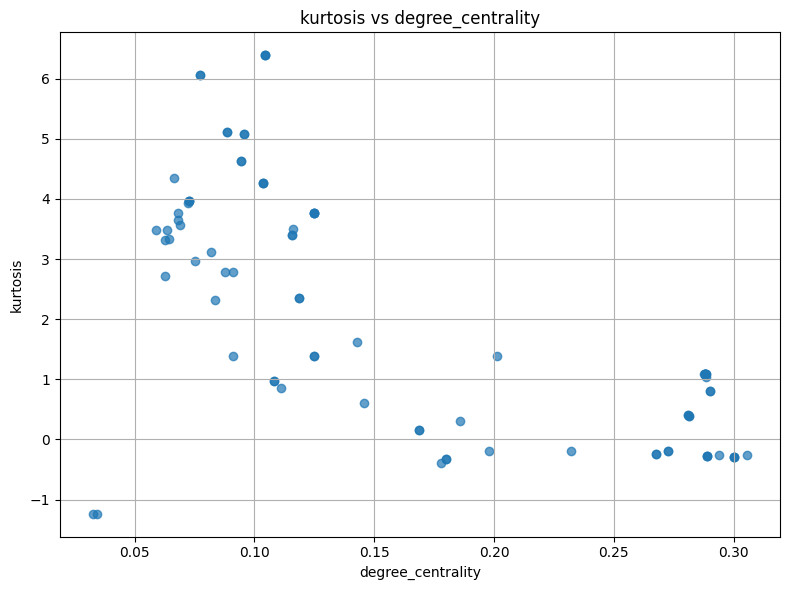

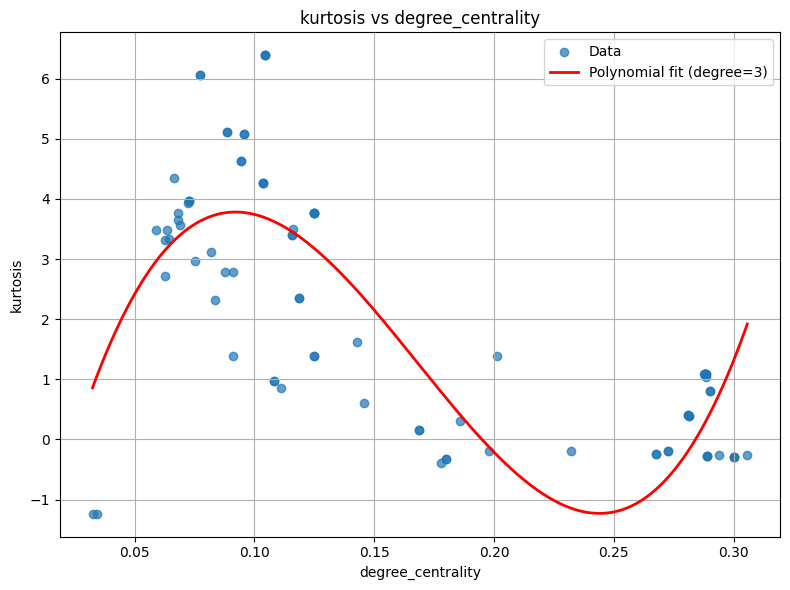

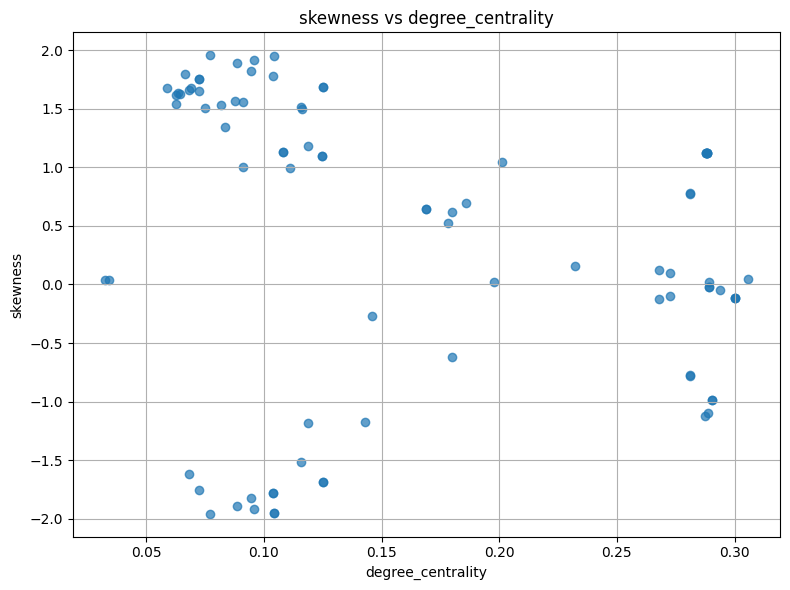

In [365]:

plot_scatter_from_df(stats_df_0, x_col="degree_centrality", y_col="kurtosis", title="")

plot_scatter_with_polyfit(stats_df_0, x_col="degree_centrality", y_col="kurtosis", degree=3, title="")

plot_scatter_from_df(stats_df_0, x_col="degree_centrality", y_col="skewness", title="")


### Identify correlations between graph centrality metrics and flux distributions obtained from the `samples_optgp_condition_100` array

In [369]:

stats_df_100 = build_statistics_dataframe(samples_optgp_condition_100, ec_cobra_reaction_ids, centrality_dict_100)

(filtered_spearman_betweenness_correlations, 
 filtered_pearson_betweenness_correlations, 
 filtered_spearman_degree_correlations,
 filtered_pearson_degree_correlations, 
 filtered_spearman_clustering_correlations,
 filtered_pearson_clustering_correlations) = graph_centrality_flux_distribution_correlation(stats_df_100, cutoff=0.3)

print(filtered_spearman_betweenness_correlations, "\n")
print(filtered_pearson_betweenness_correlations, "\n")
print(filtered_spearman_degree_correlations, "\n")
print(filtered_pearson_degree_correlations, "\n")
print(filtered_spearman_clustering_correlations, "\n")
print(filtered_pearson_clustering_correlations, "\n")


std               0.345280
range             0.322534
skewness         -0.345361
kurtosis         -0.304450
iqr               0.357802
mean_abs          0.353735
min_abs           0.386599
max_abs           0.356435
median_abs        0.355533
mean_abs_range    0.432974
Name: betweenness_centrality, dtype: float64 

skewness   -0.301157
Name: betweenness_centrality, dtype: float64 

mean              0.370858
min               0.398735
max               0.372374
median            0.370508
std               0.677365
range             0.655453
kurtosis         -0.654651
iqr               0.694304
mean_abs          0.618050
min_abs           0.657818
max_abs           0.618990
median_abs        0.617207
mean_abs_range    0.736948
Name: degree_centrality, dtype: float64 

kurtosis   -0.503083
min_abs     0.476462
Name: degree_centrality, dtype: float64 

std               0.717188
range             0.689793
skewness         -0.150544
kurtosis         -0.638029
iqr               0.734112
mea

/tmp/ipykernel_22608/1572711293.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(reaction_samples)
/tmp/ipykernel_22608/1572711293.py:42: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = stats.kurtosis(reaction_samples)


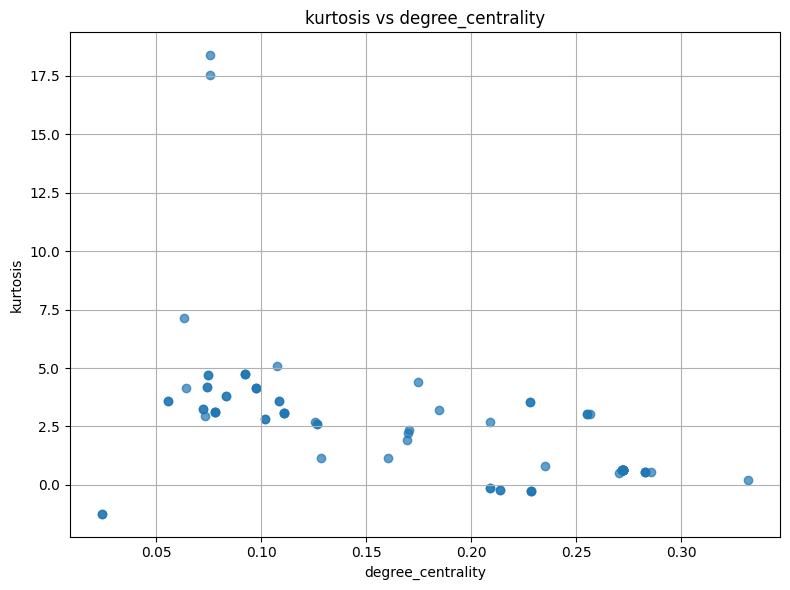

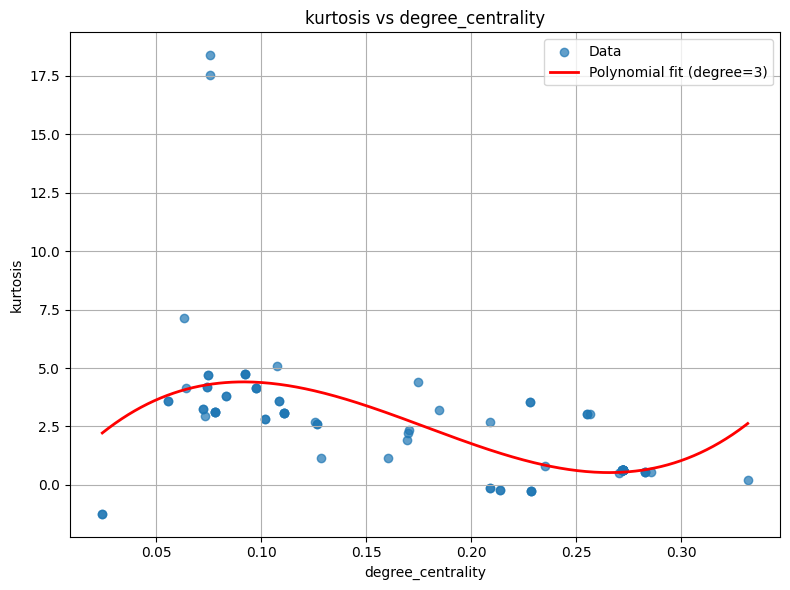

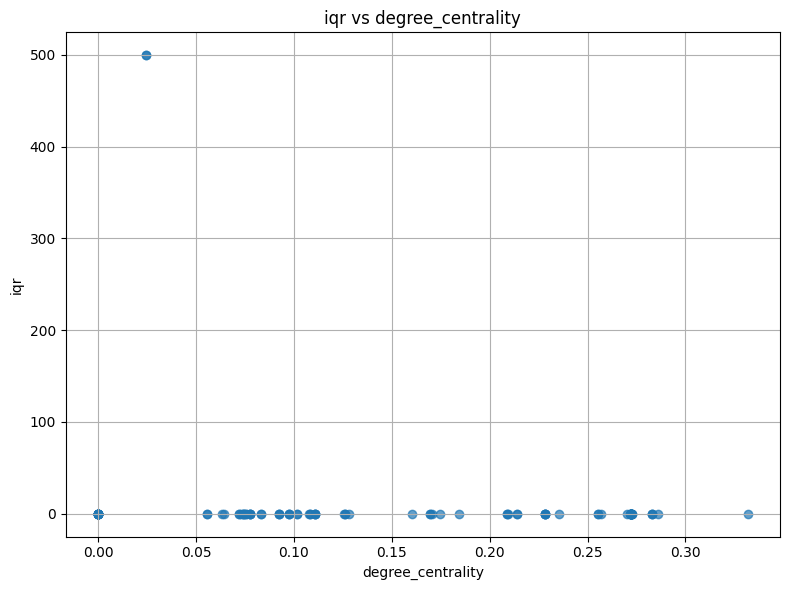

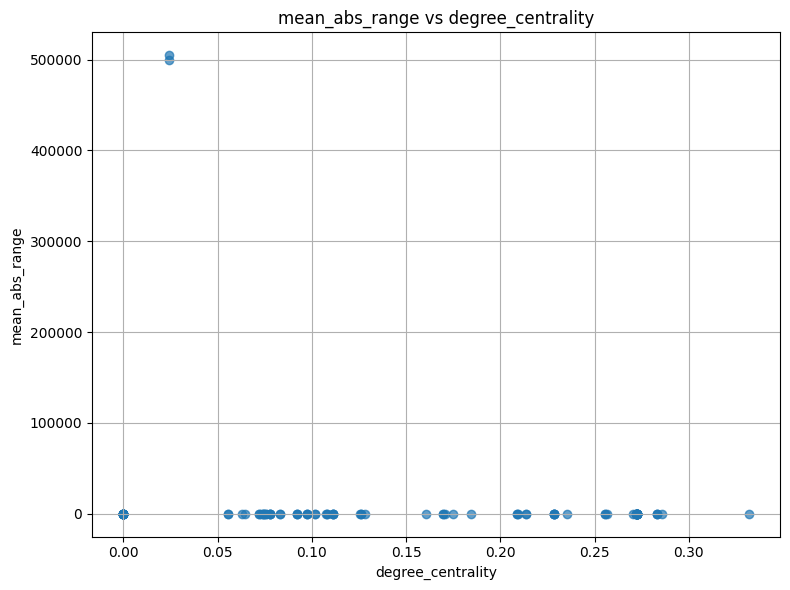

In [ ]:

plot_scatter_from_df(stats_df_100, x_col="degree_centrality", y_col="kurtosis", title="")

plot_scatter_with_polyfit(stats_df_100, x_col="degree_centrality", y_col="kurtosis", degree=3, title="")

plot_scatter_from_df(stats_df_100, x_col="degree_centrality", y_col="iqr", title="")


### Use Random Forest algorithm to check for feature importance onreaction essentiality and graph centrality metrics

Check which variable/feature from flux graph centrality metrics is more crucial to determine reaction essentiality

In [343]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Create a dictionary mapping reaction IDs to essentiality status

In [381]:
# list(stats_df_0.index)

from cobra.flux_analysis.variability import find_essential_reactions

# Optimize the model
solution = ec_cobra_model.optimize()
obj_sol = solution.objective_value
obj_sol_threshold = obj_sol * 0.999

# Identify essential reactions
essential_reactions = find_essential_reactions(ec_cobra_model, threshold=obj_sol_threshold)
essential_ids = {reaction.id for reaction in essential_reactions}

# Build essentiality dictionary
reaction_essentiality = {
    reaction.id: ("essential" if reaction.id in essential_ids else "non_essential")
    for reaction in ec_cobra_model.reactions
}

print(reaction_essentiality)

{'PFK': 'essential', 'PFL': 'non_essential', 'PGI': 'essential', 'PGK': 'essential', 'PGL': 'essential', 'ACALD': 'non_essential', 'AKGt2r': 'non_essential', 'PGM': 'essential', 'PIt2r': 'essential', 'ALCD2x': 'non_essential', 'ACALDt': 'non_essential', 'ACKr': 'non_essential', 'PPC': 'essential', 'ACONTa': 'essential', 'ACONTb': 'essential', 'ATPM': 'non_essential', 'PPCK': 'non_essential', 'ACt2r': 'non_essential', 'PPS': 'non_essential', 'ADK1': 'non_essential', 'AKGDH': 'essential', 'ATPS4r': 'essential', 'PTAr': 'non_essential', 'PYK': 'essential', 'BIOMASS_Ecoli_core_w_GAM': 'essential', 'PYRt2': 'non_essential', 'CO2t': 'essential', 'RPE': 'essential', 'CS': 'essential', 'RPI': 'essential', 'SUCCt2_2': 'non_essential', 'CYTBD': 'essential', 'D_LACt2': 'non_essential', 'ENO': 'essential', 'SUCCt3': 'non_essential', 'ETOHt2r': 'non_essential', 'SUCDi': 'essential', 'SUCOAS': 'essential', 'TALA': 'essential', 'THD2': 'non_essential', 'TKT1': 'essential', 'TKT2': 'essential', 'TPI':

First try on the 0% opt. dataset

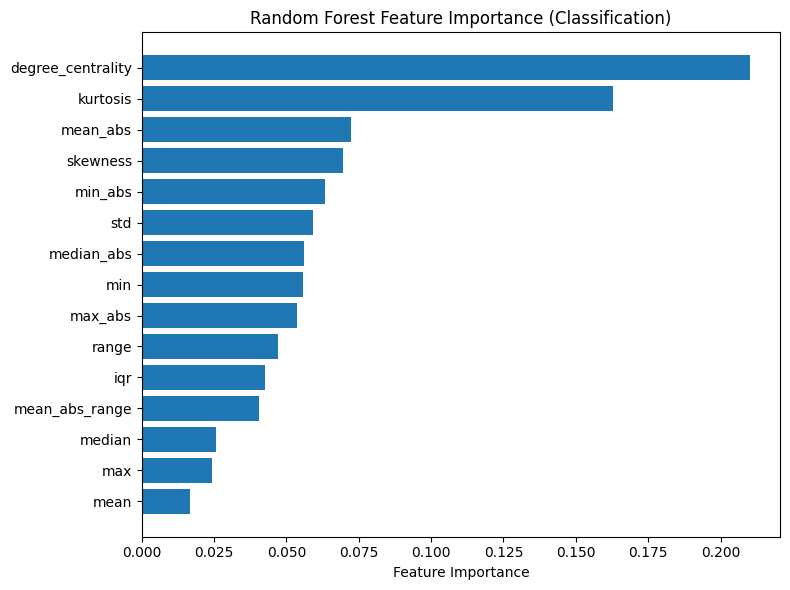

In [389]:

df = stats_df_0.dropna()
df["essential"] = df.index.map(reaction_essentiality)
df = df.drop(["betweenness_centrality", "clustering_coefficient"], axis=1)
df = df[df["degree_centrality"] > 0]

X = df.drop("degree_centrality", axis=1)
y = df["degree_centrality"]

# Prepare data
X = df.drop("essential", axis=1)
y = df["essential"].astype("category").cat.codes  # encode if needed

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Feature importance
importances = clf.feature_importances_
features = X.columns

# Plot
sorted_idx = importances.argsort()[::-1]  # descending order
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Classification)")
plt.tight_layout()
plt.show()


Visualize most important features distribution with boxplots

/tmp/ipykernel_22608/1532321042.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, patch_artist=True)


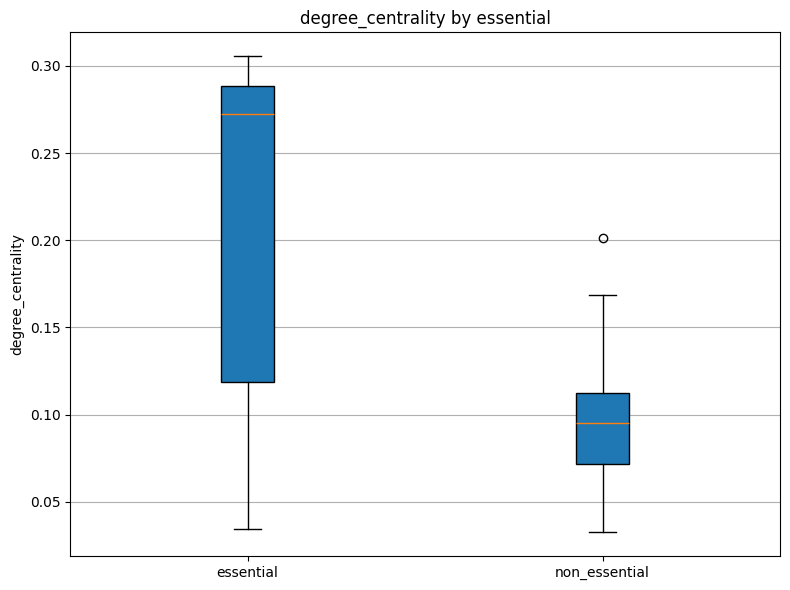

In [394]:
df = stats_df_0.dropna()
df["essential"] = df.index.map(reaction_essentiality)

value_col = "degree_centrality"
group_col = "essential"

groups = df[group_col].unique()
data = [df[df[group_col] == g][value_col].dropna() for g in groups]

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=groups, patch_artist=True)
plt.ylabel(value_col)
plt.title(f"{value_col} by {group_col}")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Try on the 100% opt. dataset

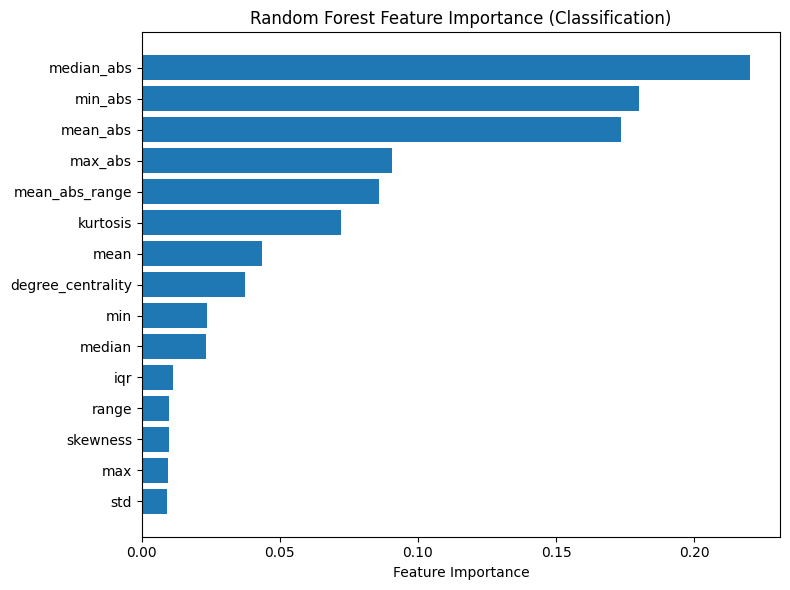

In [390]:

df = stats_df_100.dropna()
df["essential"] = df.index.map(reaction_essentiality)
df = df.drop(["betweenness_centrality", "clustering_coefficient"], axis=1)
df = df[df["degree_centrality"] > 0]

X = df.drop("degree_centrality", axis=1)
y = df["degree_centrality"]

# Prepare data
X = df.drop("essential", axis=1)
y = df["essential"].astype("category").cat.codes  # encode if needed

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Feature importance
importances = clf.feature_importances_
features = X.columns

# Plot
sorted_idx = importances.argsort()[::-1]  # descending order
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Classification)")
plt.tight_layout()
plt.show()


Visualize most important features distribution with boxplots

/tmp/ipykernel_22608/399051639.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups, patch_artist=True)


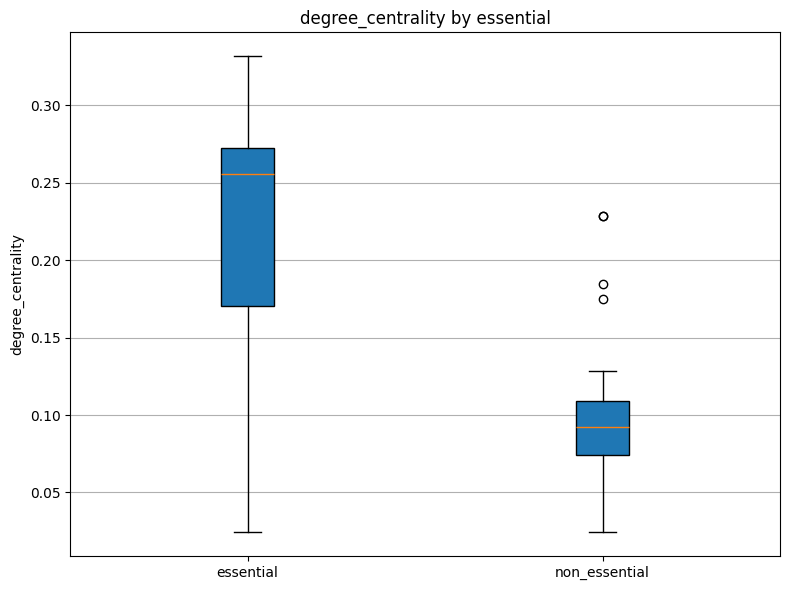

In [395]:
df = stats_df_100.dropna()
df["essential"] = df.index.map(reaction_essentiality)

value_col = "degree_centrality"
group_col = "essential"

groups = df[group_col].unique()
data = [df[df[group_col] == g][value_col].dropna() for g in groups]

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=groups, patch_artist=True)
plt.ylabel(value_col)
plt.title(f"{value_col} by {group_col}")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Check which variable/feature from flux sampling distributions is more crucial to determine degree centrality

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

First try on the 0% opt. dataset

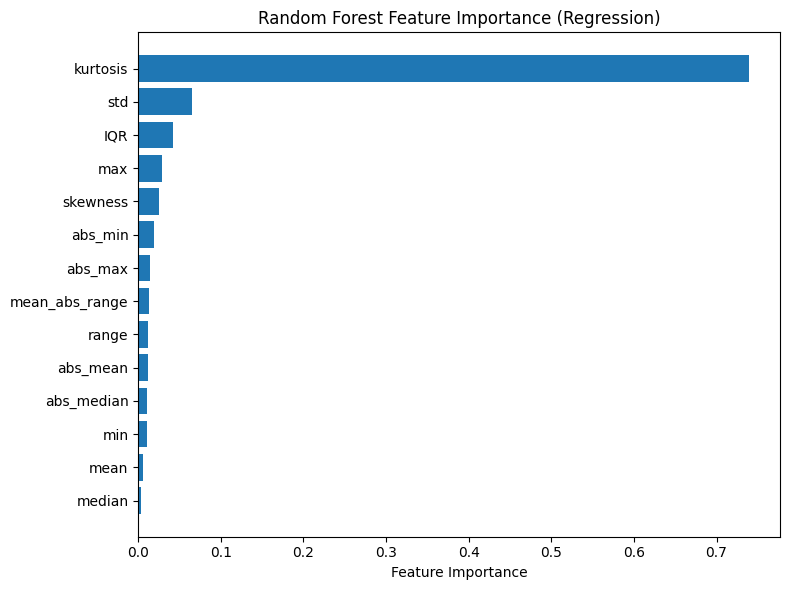

In [325]:

df = stats_df_0.dropna()
df = df.drop(["betweenness_centrality", "clustering_coefficient"], axis=1)
df = df[df["degree_centrality"] > 0]

X = df.drop("degree_centrality", axis=1)
y = df["degree_centrality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Feature importance
importances = reg.feature_importances_
features = X.columns

# Plot
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Regression)")
plt.tight_layout()
plt.show()


Now try on the 100% opt. dataset

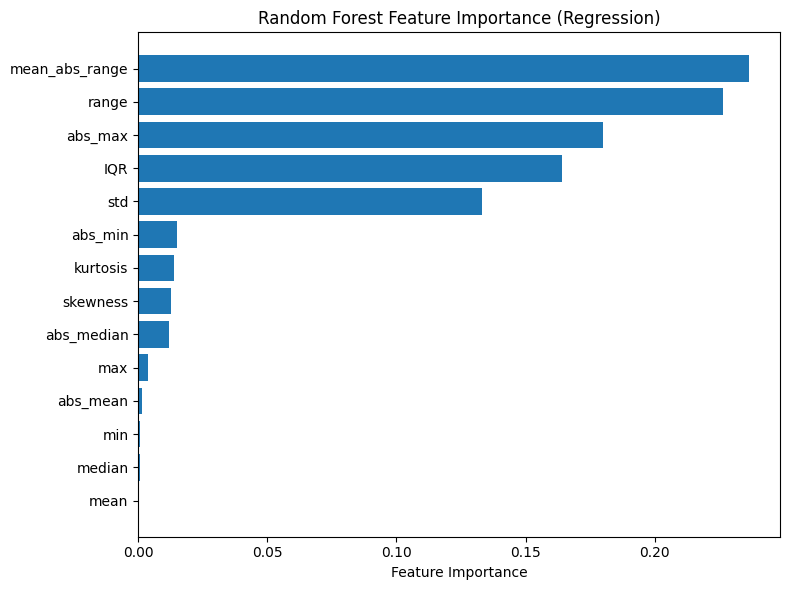

In [ ]:

df = stats_df_100.dropna()
df = df.drop(["betweenness_centrality", "clustering_coefficient"], axis=1)
df = df[df["degree_centrality"] > 0]

X = df.drop("degree_centrality", axis=1)
y = df["degree_centrality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

# Feature importance
importances = reg.feature_importances_
features = X.columns

# Plot
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (Regression)")
plt.tight_layout()
plt.show()
